In [ ]:
# Reinforcement Learning Lab 2, Problem 3, produce ALL the plots
# Oscar Eriksson, 0011301991, oscer@kth.se
# Philip Ahrendt, 960605R119, pcah@kth.se

In [1]:
# Load packages
import numpy as np
import gym
import torch
import matplotlib.pyplot as plt
from collections import deque
from tqdm import trange
from torch import nn
from PPO_agent import RandomAgent
from PPO import Actor, Critic
from torch.distributions import MultivariateNormal

def running_average(x, N):
    ''' Function used to compute the running average
        of the last N elements of a vector x
    '''
    if len(x) >= N:
        y = np.copy(x)
        y[N-1:] = np.convolve(x, np.ones((N, )) / N, mode='valid')
    else:
        y = np.zeros_like(x)
    return y

Episode:   0%|          | 0/1600 [00:00<?, ?it/s]

/tmp/ipykernel_169765/1478158937.py:48: RuntimeWarning: overflow encountered in power
  g = discount_factor**(k - i)
Episode 1599 - Reward/Steps: -107.9/169 - Avg. Reward/Steps: -194.4/229: 100%|██████████| 1600/1600 [48:29<00:00,  1.82s/it] 


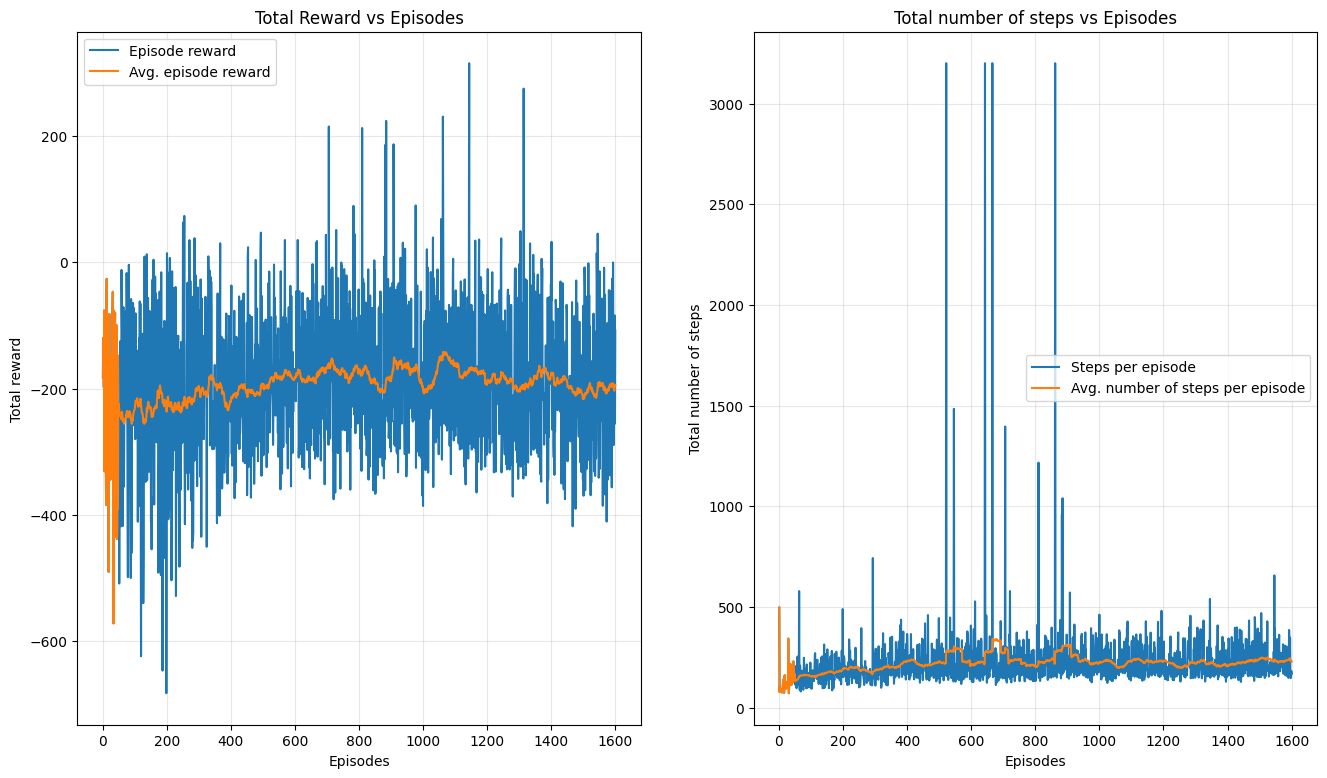

Episode 1599 - Reward/Steps: -2.7/129 - Avg. Reward/Steps: 191.1/227: 100%|██████████| 1600/1600 [1:07:01<00:00,  2.51s/it]   


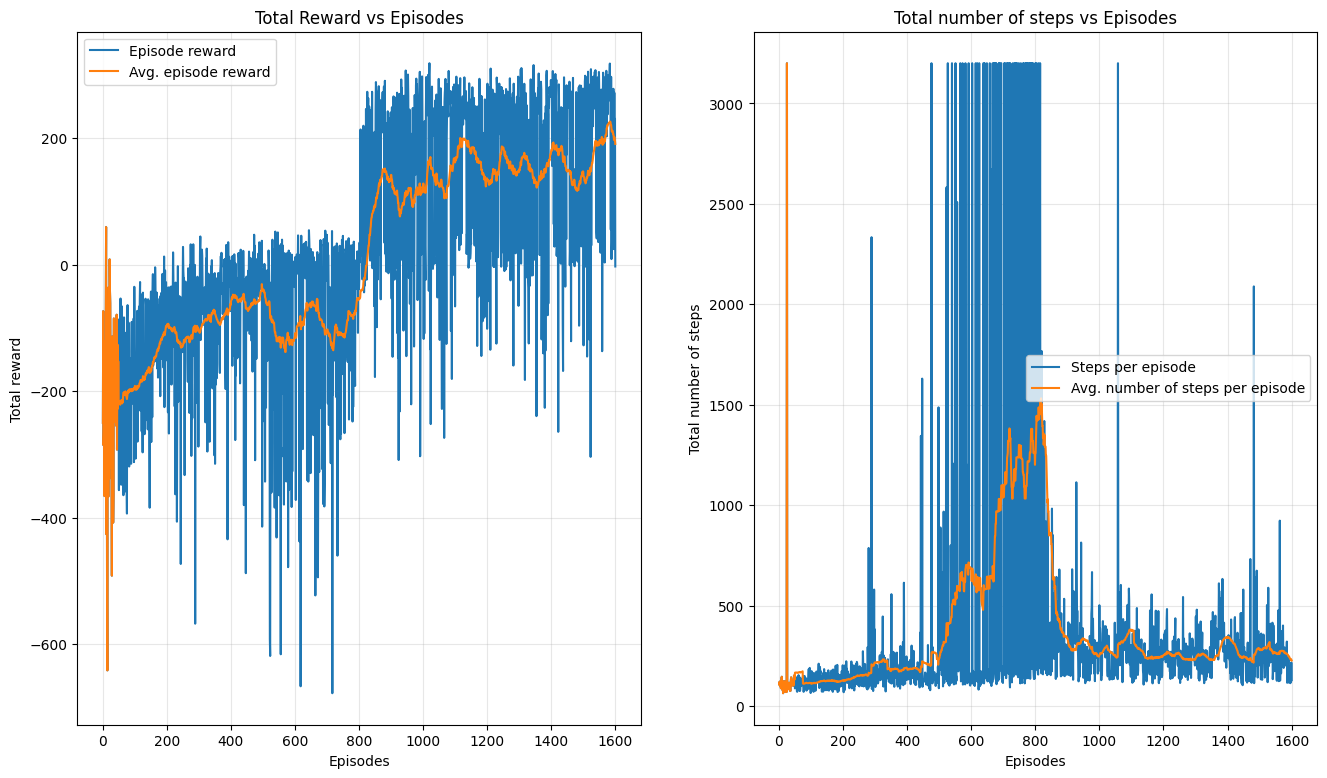

Episode 1599 - Reward/Steps: -8.3/169 - Avg. Reward/Steps: -66.8/253: 100%|██████████| 1600/1600 [1:04:48<00:00,  2.43s/it]    


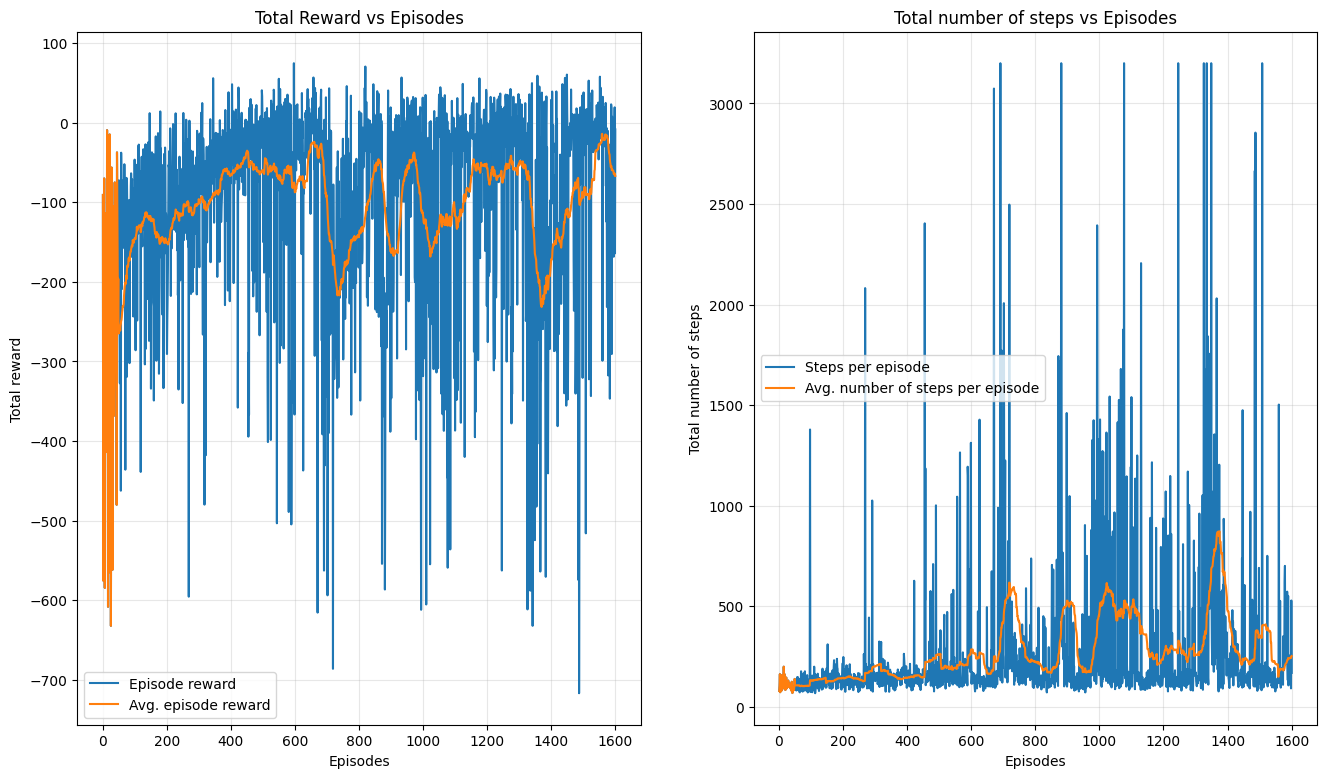

In [4]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

# Hyperparameters
ep = 0.2
M = 10
N_episodes = 1600
discount_factor = 0.99
critic_learning_rate = 1e-3
actor_learning_rate = 1e-5

for discount_factor in [ 0.20, 0.99, 1.00 ]:
    episode_reward_list = [] 
    episode_number_of_steps = [] 
    # Experience replay buffer
    experience_replay_buffer = []
    
    # Initialize networks, optimizer and loss function
    network_actor = Actor(S, A)
    network_critic = Critic(S, A)
    
    optimizer_critic = torch.optim.Adam(network_critic.parameters(), lr=critic_learning_rate)
    optimizer_actor = torch.optim.Adam(network_actor.parameters(), lr=actor_learning_rate)
    loss_fn = nn.MSELoss()
    
    def clip(x):
        _ep = torch.tensor(len(x) * [ ep ]).reshape((-1, 1))
        return torch.max(1 - _ep, torch.min(1 + _ep, x))
    
    def train_network(network_actor: Actor, network_critic: Critic):
        # create torch tensors from experience replay buffer
        t = len(experience_replay_buffer)
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((t, -1)), zip(*experience_replay_buffer))
    
        # compute G
        i = np.arange(t).reshape((-1, 1))
        k = np.arange(t).reshape((1, -1))
        g = discount_factor**(k - i)
        g[~(k >= i)] = 0
        G = torch.tensor(g).float() @ rewards
    
        # compute advantage estimation
        advantage_estimation = (G - network_critic(states)).detach()
    
        # compute old log probabilities
        mu, cov = network_actor(states)
        mu_old = mu.detach()
        cov_old = cov.detach()
        mv_old = MultivariateNormal(mu_old, torch.diag_embed(cov_old))
        log_probs_old = mv_old.log_prob(actions)
    
        # update networks
        for _ in range(M):
            """ critic update """
            optimizer_critic.zero_grad()
    
            # compute loss
            loss_critic = loss_fn(G, network_critic(states))
    
            loss_critic.backward()
            nn.utils.clip_grad_norm_(network_critic.parameters(), max_norm=1)
            optimizer_critic.step()
    
            """ actor update """
            optimizer_actor.zero_grad()
    
            # compute new log probabilities
            mu, cov = network_actor(states)
            mv = MultivariateNormal(mu, torch.diag_embed(cov))
            log_probs = mv.log_prob(actions)
    
            # exp(log(a) - log(b)) = a / b
            r_theta = torch.exp(log_probs - log_probs_old).reshape((-1, 1))
    
            # compute loss
            loss_actor = -torch.mean(torch.minimum(
                r_theta * advantage_estimation,
                clip(r_theta) * advantage_estimation
            ))
    
            loss_actor.backward()
            nn.utils.clip_grad_norm_(network_actor.parameters(), max_norm=1)
            optimizer_actor.step()
    
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
    for i in EPISODES:
        done = False
        state, _ = env.reset()
        total_episode_reward = 0.
        experience_replay_buffer = []
        t = 0
        #while not done:
        for _ in range(3200):
            if done: break
            action = network_actor.act(state).ravel()
            next_state, reward, done, _, _ = env.step(action)
            total_episode_reward += reward
    
            # train
            experience_replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            t += 1
        
        train_network(network_actor, network_critic)
    
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)
    
        env.close()
    
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
    
    while len(episode_reward_list) < N_episodes:
        episode_reward_list.append(episode_reward_list[-1])
        episode_number_of_steps.append(episode_number_of_steps[-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
    ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_reward_list, n_ep_running_average), label='Avg. episode reward')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Total reward')
    ax[0].set_title('Total Reward vs Episodes')
    ax[0].legend()
    ax[0].grid(alpha=0.3)
    
    ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
    ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Total number of steps')
    ax[1].set_title('Total number of steps vs Episodes')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.show()

Episode 1599 - Reward/Steps: 260.4/227 - Avg. Reward/Steps: 231.4/283: 100%|██████████| 1600/1600 [4:07:29<00:00,  9.28s/it]     


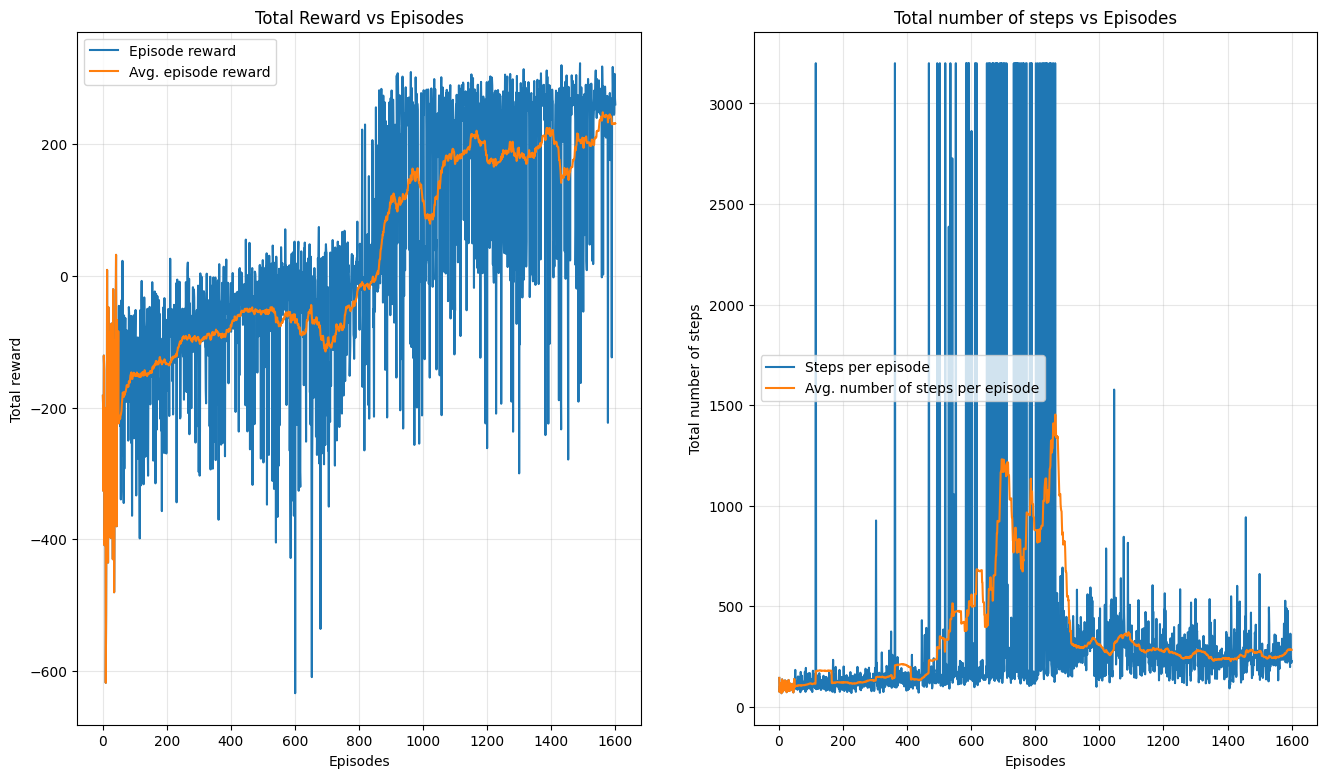

Episode 1599 - Reward/Steps: 262.2/212 - Avg. Reward/Steps: 171.3/295: 100%|██████████| 1600/1600 [2:07:15<00:00,  4.77s/it]    


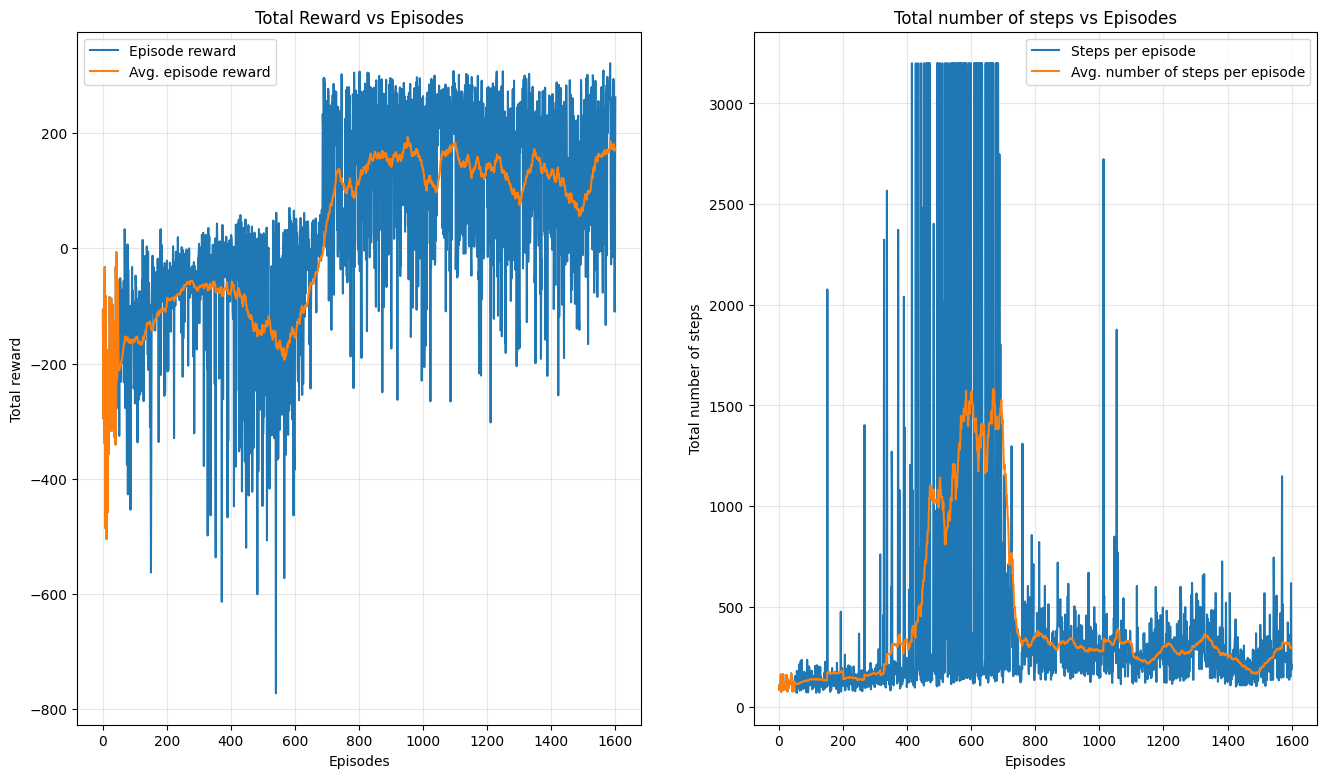

Episode 1599 - Reward/Steps: 275.1/291 - Avg. Reward/Steps: 181.1/282: 100%|██████████| 1600/1600 [1:06:08<00:00,  2.48s/it]  


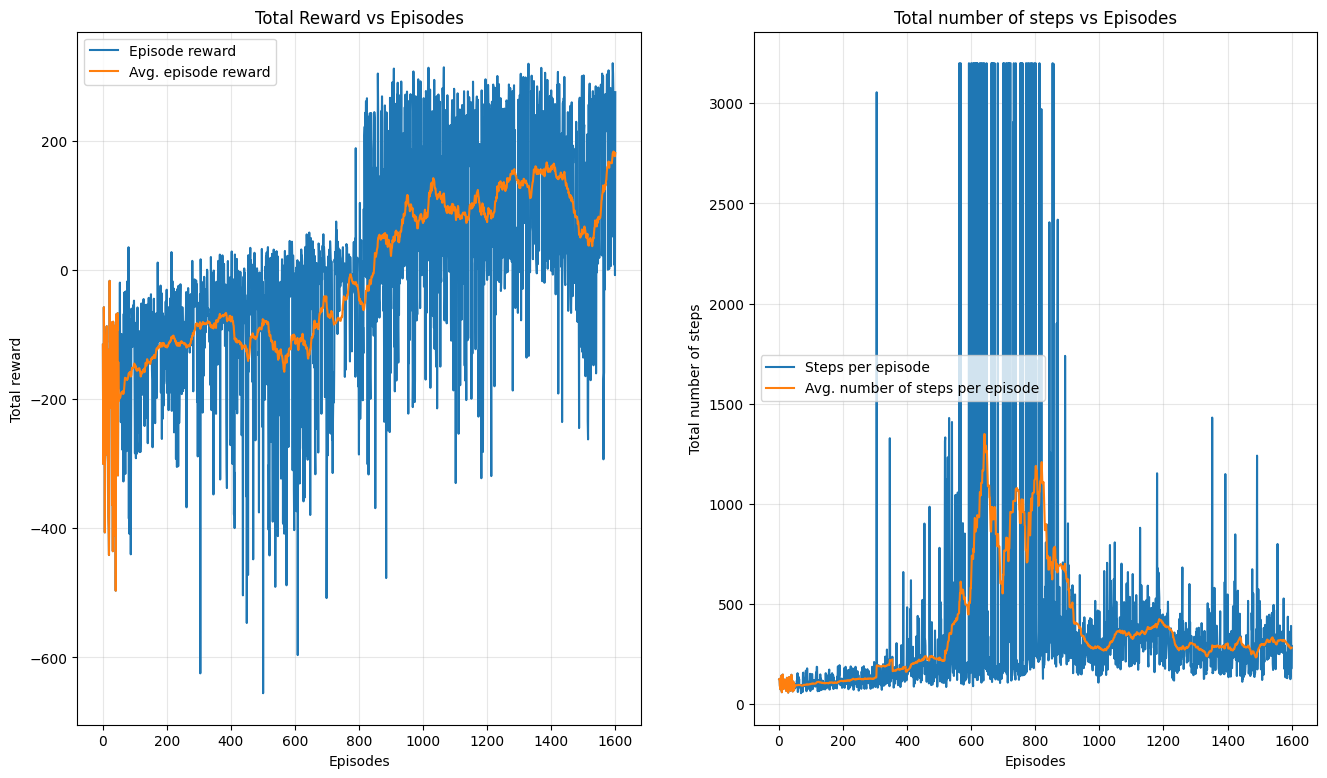

In [5]:

env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

# Hyperparameters
ep = 0.2
M = 10
N_episodes = 1600
discount_factor = 0.99
critic_learning_rate = 1e-3
actor_learning_rate = 1e-5

for ep in [ 0.1, 0.2, 0.5 ]:
    episode_reward_list = [] 
    episode_number_of_steps = [] 
    # Experience replay buffer
    experience_replay_buffer = []
    
    # Initialize networks, optimizer and loss function
    network_actor = Actor(S, A)
    network_critic = Critic(S, A)
    
    optimizer_critic = torch.optim.Adam(network_critic.parameters(), lr=critic_learning_rate)
    optimizer_actor = torch.optim.Adam(network_actor.parameters(), lr=actor_learning_rate)
    loss_fn = nn.MSELoss()
    
    def clip(x):
        _ep = torch.tensor(len(x) * [ ep ]).reshape((-1, 1))
        return torch.max(1 - _ep, torch.min(1 + _ep, x))
    
    def train_network(network_actor: Actor, network_critic: Critic):
        # create torch tensors from experience replay buffer
        t = len(experience_replay_buffer)
        states, actions, rewards, next_states, dones = map(lambda x: torch.tensor(x).float().reshape((t, -1)), zip(*experience_replay_buffer))
    
        # compute G
        i = np.arange(t).reshape((-1, 1))
        k = np.arange(t).reshape((1, -1))
        g = discount_factor**(k - i)
        g[~(k >= i)] = 0
        G = torch.tensor(g).float() @ rewards
    
        # compute advantage estimation
        advantage_estimation = (G - network_critic(states)).detach()
    
        # compute old log probabilities
        mu, cov = network_actor(states)
        mu_old = mu.detach()
        cov_old = cov.detach()
        mv_old = MultivariateNormal(mu_old, torch.diag_embed(cov_old))
        log_probs_old = mv_old.log_prob(actions)
    
        # update networks
        for _ in range(M):
            """ critic update """
            optimizer_critic.zero_grad()
    
            # compute loss
            loss_critic = loss_fn(G, network_critic(states))
    
            loss_critic.backward()
            nn.utils.clip_grad_norm_(network_critic.parameters(), max_norm=1)
            optimizer_critic.step()
    
            """ actor update """
            optimizer_actor.zero_grad()
    
            # compute new log probabilities
            mu, cov = network_actor(states)
            mv = MultivariateNormal(mu, torch.diag_embed(cov))
            log_probs = mv.log_prob(actions)
    
            # exp(log(a) - log(b)) = a / b
            r_theta = torch.exp(log_probs - log_probs_old).reshape((-1, 1))
    
            # compute loss
            loss_actor = -torch.mean(torch.minimum(
                r_theta * advantage_estimation,
                clip(r_theta) * advantage_estimation
            ))
    
            loss_actor.backward()
            nn.utils.clip_grad_norm_(network_actor.parameters(), max_norm=1)
            optimizer_actor.step()
    
    EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
    for i in EPISODES:
        done = False
        state, _ = env.reset()
        total_episode_reward = 0.
        experience_replay_buffer = []
        t = 0
        #while not done:
        for _ in range(3200):
            if done: break
            action = network_actor.act(state).ravel()
            next_state, reward, done, _, _ = env.step(action)
            total_episode_reward += reward
    
            # train
            experience_replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            t += 1
        
        train_network(network_actor, network_critic)
    
        episode_reward_list.append(total_episode_reward)
        episode_number_of_steps.append(t)
    
        env.close()
    
        EPISODES.set_description(
            "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
            i, total_episode_reward, t,
            running_average(episode_reward_list, n_ep_running_average)[-1],
            running_average(episode_number_of_steps, n_ep_running_average)[-1]))
    
    while len(episode_reward_list) < N_episodes:
        episode_reward_list.append(episode_reward_list[-1])
        episode_number_of_steps.append(episode_number_of_steps[-1])
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
    ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_reward_list, n_ep_running_average), label='Avg. episode reward')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Total reward')
    ax[0].set_title('Total Reward vs Episodes')
    ax[0].legend()
    ax[0].grid(alpha=0.3)
    
    ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
    ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
        episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Total number of steps')
    ax[1].set_title('Total number of steps vs Episodes')
    ax[1].legend()
    ax[1].grid(alpha=0.3)
    plt.show()

Episode 0 - Reward/Steps: 226.9/240 - Avg. Reward/Steps: 0.0/0:   2%|▏         | 1/50 [00:00<00:11,  4.36it/s]

Episode 49 - Reward/Steps: 281.8/224 - Avg. Reward/Steps: 227.3/279: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


[]

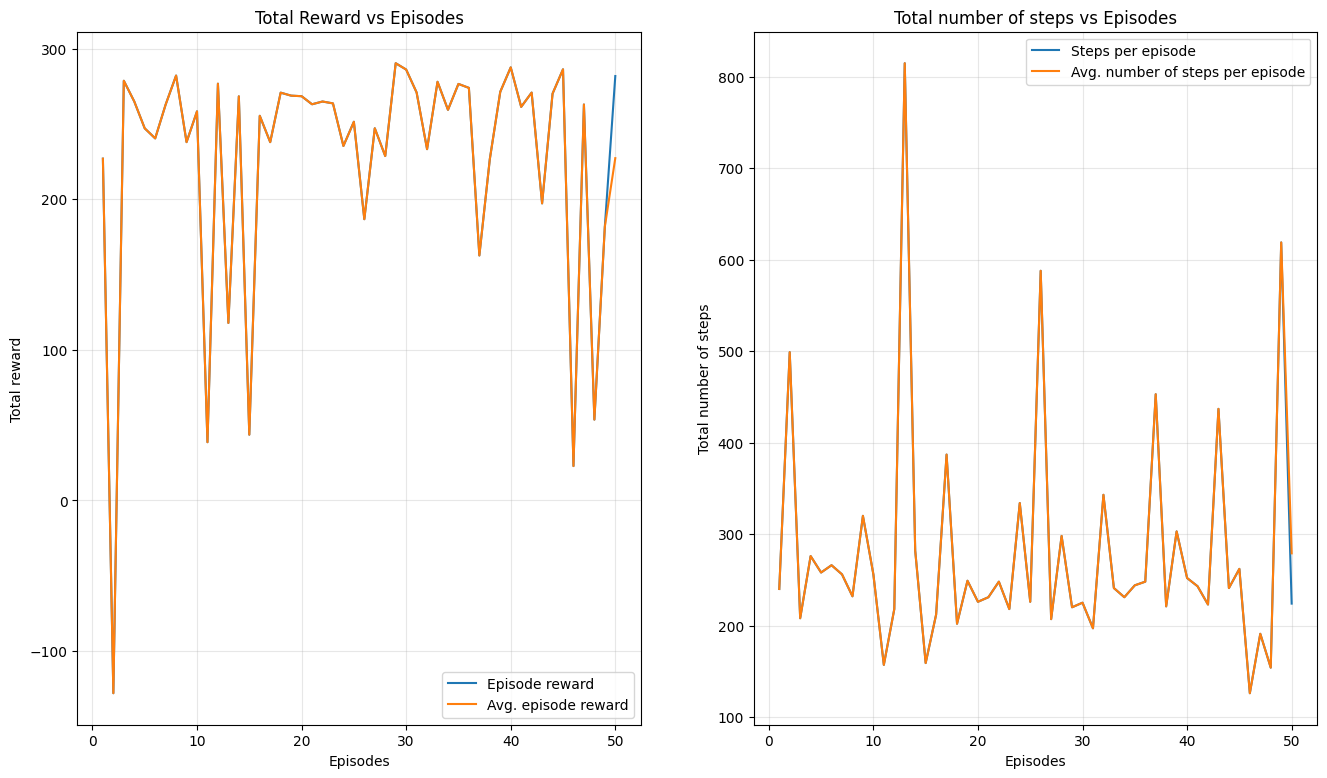

In [3]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

N_episodes = 50
episode_reward_list = [] 
episode_number_of_steps = [] 

# Initialize networks, optimizer and loss function
model = torch.load('neural-network-3-actor.pth')

EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    t = 0
    for _ in range(3200):
        if done: break
        action = model.act(state).ravel()
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        state = next_state
        t += 1

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.plot()

Episode 49 - Reward/Steps: -52.1/80 - Avg. Reward/Steps: -238.9/171: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


[]

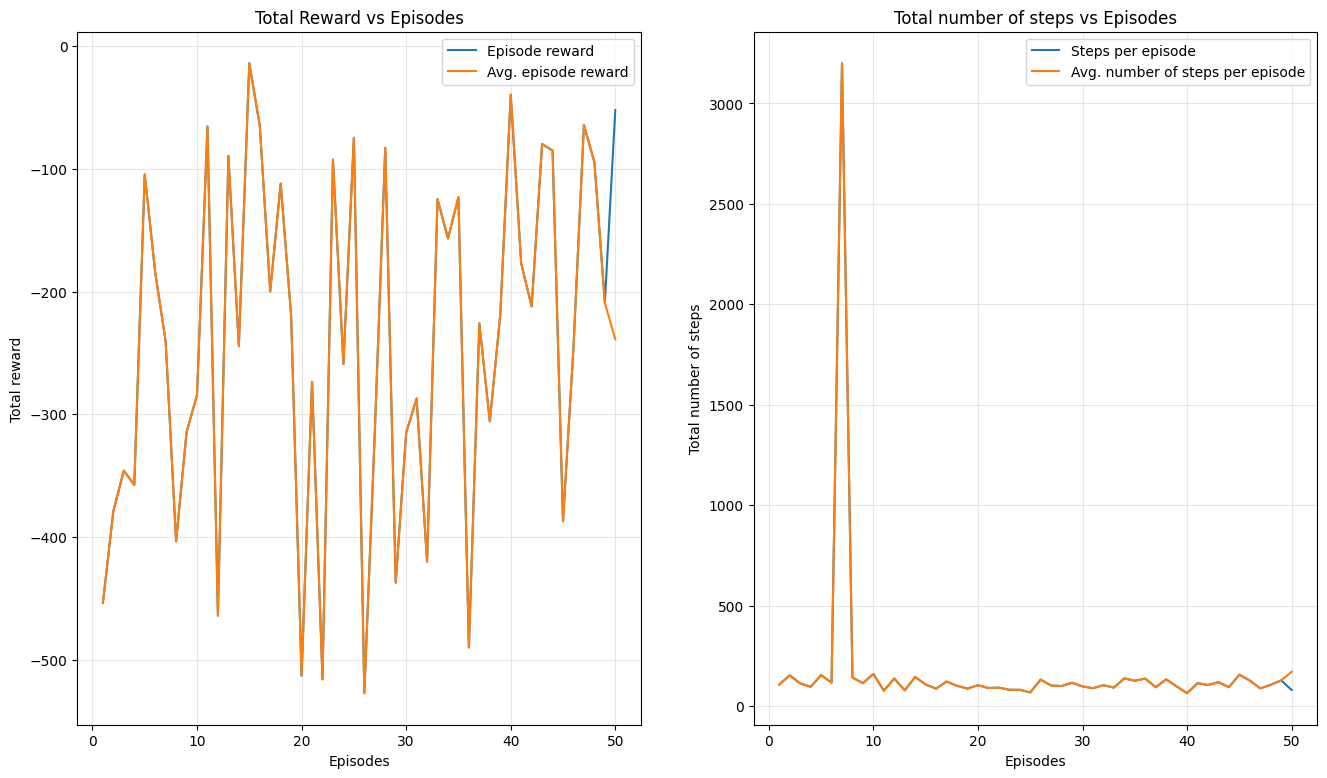

In [4]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()

# State/action space description
S = 8
A = 2
E = S + A + 1 + S + 1 # S, A, R, S', done

# Utility parameters
n_ep_running_average = 50                    
m = len(env.action_space.high) # dimensionality of the action
dim_state = len(env.observation_space.high)  

N_episodes = 50
episode_reward_list = [] 
episode_number_of_steps = [] 

# Initialize networks, optimizer and loss function
model = RandomAgent(m)

EPISODES = trange(N_episodes, desc='Episode: ', leave=True)
for i in EPISODES:
    done = False
    state, _ = env.reset()
    total_episode_reward = 0.
    t = 0
    for _ in range(3200):
        if done: break
        action = model.forward(state).ravel()
        next_state, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

        state = next_state
        t += 1

    episode_reward_list.append(total_episode_reward)
    episode_number_of_steps.append(t)

    env.close()

    EPISODES.set_description(
        "Episode {} - Reward/Steps: {:.1f}/{} - Avg. Reward/Steps: {:.1f}/{}".format(
        i, total_episode_reward, t,
        running_average(episode_reward_list, n_ep_running_average)[-1],
        running_average(episode_number_of_steps, n_ep_running_average)[-1]))

while len(episode_reward_list) < N_episodes:
    episode_reward_list.append(episode_reward_list[-1])
    episode_number_of_steps.append(episode_number_of_steps[-1])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
ax[0].plot([i for i in range(1, N_episodes+1)], episode_reward_list, label='Episode reward')
ax[0].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_reward_list, n_ep_running_average), label='Avg. episode reward')
ax[0].set_xlabel('Episodes')
ax[0].set_ylabel('Total reward')
ax[0].set_title('Total Reward vs Episodes')
ax[0].legend()
ax[0].grid(alpha=0.3)

ax[1].plot([i for i in range(1, N_episodes+1)], episode_number_of_steps, label='Steps per episode')
ax[1].plot([i for i in range(1, N_episodes+1)], running_average(
    episode_number_of_steps, n_ep_running_average), label='Avg. number of steps per episode')
ax[1].set_xlabel('Episodes')
ax[1].set_ylabel('Total number of steps')
ax[1].set_title('Total number of steps vs Episodes')
ax[1].legend()
ax[1].grid(alpha=0.3)
plt.plot()

/tmp/ipykernel_202770/2294990464.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


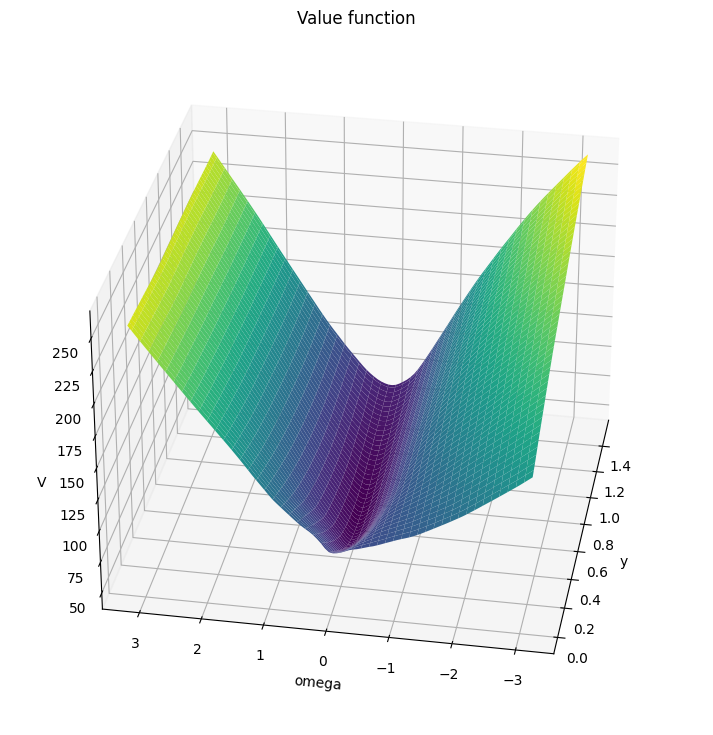

/tmp/ipykernel_202770/2294990464.py:26: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


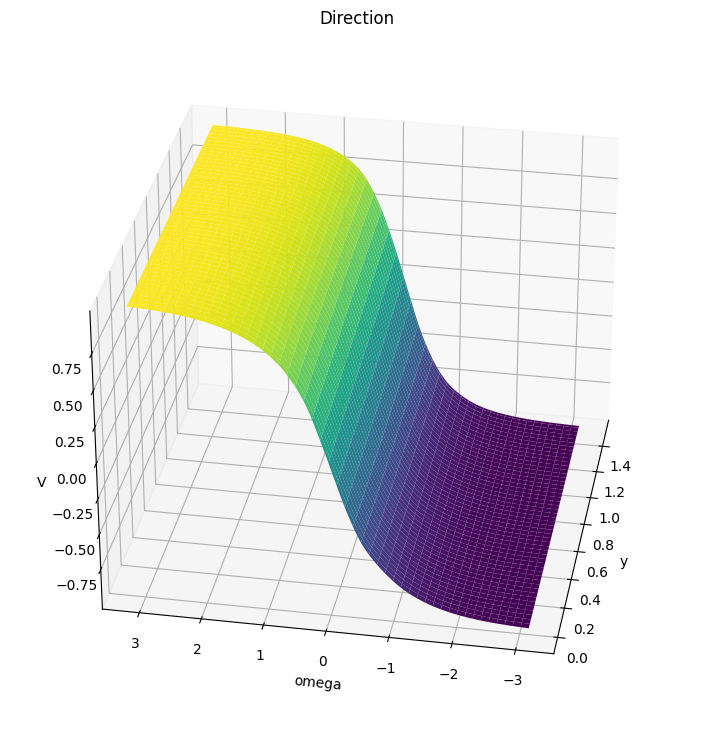

In [2]:

actor = torch.load('neural-network-3-actor.pth')
critic = torch.load('neural-network-3-critic.pth')
v_N = 100
v_y = np.linspace(0, 1.5, v_N)
v_o = np.linspace(-np.pi, np.pi, v_N)

# 3d plot
V_y, V_o = np.meshgrid(v_y, v_o)
V_s = np.zeros((v_N**2, 8))
V_s[:, 1] = V_y.ravel()
V_s[:, 4] = V_o.ravel()
t_s = torch.tensor(V_s).float()
Z = critic(t_s).detach().numpy().reshape((v_N, v_N))
U = actor(t_s)[0][:,1].detach().numpy().reshape((v_N, v_N))

fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(V_y, V_o, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('omega')
ax.set_zlabel('V')
ax.set_title('Value function')
ax.view_init(30, 190)
plt.show()
fig = plt.figure(figsize=(16, 9))
ax = fig.gca(projection='3d')
ax.plot_surface(V_y, V_o, U, cmap='viridis', edgecolor='none')
ax.set_xlabel('y')
ax.set_ylabel('omega')
ax.set_zlabel('V')
ax.set_title('Direction')
ax.view_init(30, 190)
plt.show()